# Part II: Road Lane Detection Using Hough Transform

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def find_edges(img,th1,th2):
    grayscale = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    denoised = cv2.medianBlur(grayscale,5)
    canny = cv2.Canny(denoised,th1,th2)
    return canny

In [23]:
def roi(img,bl=1,tl=0.5,br=(0.9,1),tr=(0.6,0.45)):
    height,width = img.shape[:2]
    roi_bottom_left = (0, height*bl)  
    roi_top_left = (0, height * tl)
    roi_top_right = (width * tr[0], height * tr[1])
    roi_bottom_right = (width * br[0], height*br[1])
    
    vertices = np.array([[roi_bottom_left, roi_top_left, roi_top_right, roi_bottom_right]], dtype=np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, (255, 255, 255)) 
    roi_img = cv2.bitwise_and(img, mask)
    
    return roi_img,vertices

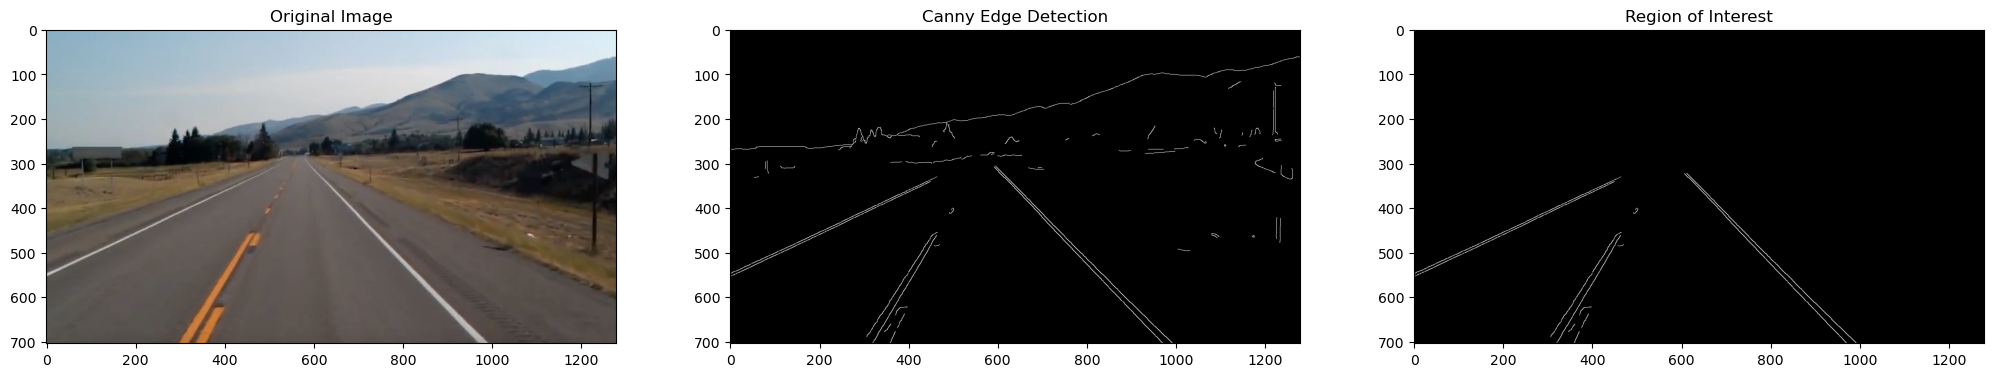

In [263]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_1.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img,poly = roi(canny)
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()

In [264]:
'''def hough_transform(roi):    
    rho = 1
    theta = np.pi/180
    threshold = 10 # min number of votes
    min_line_len = 80 # min line length to be considered (less than this length will be discarded)
    max_line_gap = 100 # max line gap between lines to be treated as one line

    line_coords = cv2.HoughLinesP(roi, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)
    polar_params = cv2.HoughLines(roi, rho, theta, threshold)

    return line_coords, polar_params'''

In [284]:
def non_max_suppression(rhos,thetas,H, rho_tolerance, theta_tolerance):
    #retained_lines = []
    retained_rhos=[]
    retained_thetas=[]
    point = np.unravel_index(np.argmax(H), H.shape)
    retained_rhos.append(point[0])
    retained_thetas.append(point[1])
    #retained_lines.append([point[0], point[1]])

    for rho,theta in zip(rhos[1:],thetas[1:]):
        if all(not np.isclose(rho, r, atol=rho_tolerance) or not np.isclose(theta, t, atol=theta_tolerance) for r, t in zip(retained_rhos,retained_thetas)):
            #retained_lines.append([rho, theta])
            retained_thetas.append(theta)
            retained_rhos.append(rho)
          

    return retained_rhos,retained_thetas

In [266]:
def hough(img, threshold = 100):
    rhos =[]
    thetas = []
    max_rho = int((np.ceil(np.sqrt((img.shape[0])**2 + (img.shape[1])**2))))
    accumulator = np.zeros((max_rho, 180))
    edge_points = np.argwhere(img>150)
    
    for point in edge_points:
        for theta in range(0,180):
            theta_rad= np.radians(theta)
            rho = point[1]* np.cos(theta_rad) + point[0] * np.sin(theta_rad)
            rho = round((rho))                  
            accumulator[rho,theta] += 1

            if accumulator[rho,theta] >= threshold:
                rhos.append(rho)
                thetas.append(theta) 
                                          
    return rhos, thetas, accumulator

In [289]:
def detect_lanes(img, poly,rhos,thetas):
  mask_lines = np.zeros(img.shape, dtype="uint8")   
  for i in range(len(rhos)):
      rho = rhos[i]
      theta = np.deg2rad(thetas[i])
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho
      x1 = int(x0 + 1500*(-b))
      y1 = int(y0 + 1500*(a))
      x2 = int(x0 - 1500*(-b))
      y2 = int(y0 - 1500*(a))

      cv2.line(mask_lines,(x1,y1),(x2,y2),(0,255,0),3)

  mask = np.zeros_like(mask_lines)
  cv2.fillPoly(mask,poly,(255,255,255))
  masked_img=cv2.bitwise_and(mask_lines,mask)
  overlay = cv2.addWeighted(img, 1, masked_img, 1, 0)
  return overlay

In [290]:
rhos,thetas,H = hough(roi_img)
output = detect_lanes(img,poly,rhos,thetas)
ret_rhos,ret_thetas = non_max_suppression(rhos,thetas,H,60,20)
refined_output= detect_lanes(img,poly,ret_rhos,ret_thetas)

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

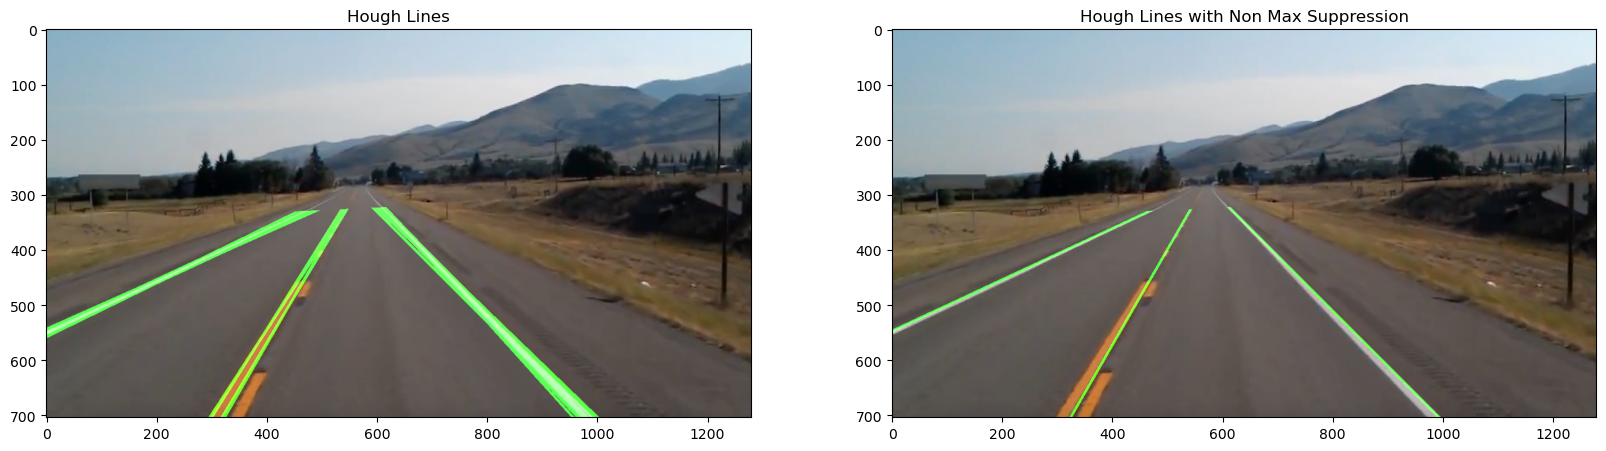

In [291]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(output)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(refined_output)
plt.title('Hough Lines with Non Max Suppression')

/home/rana/anaconda3/envs/conda_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:743: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

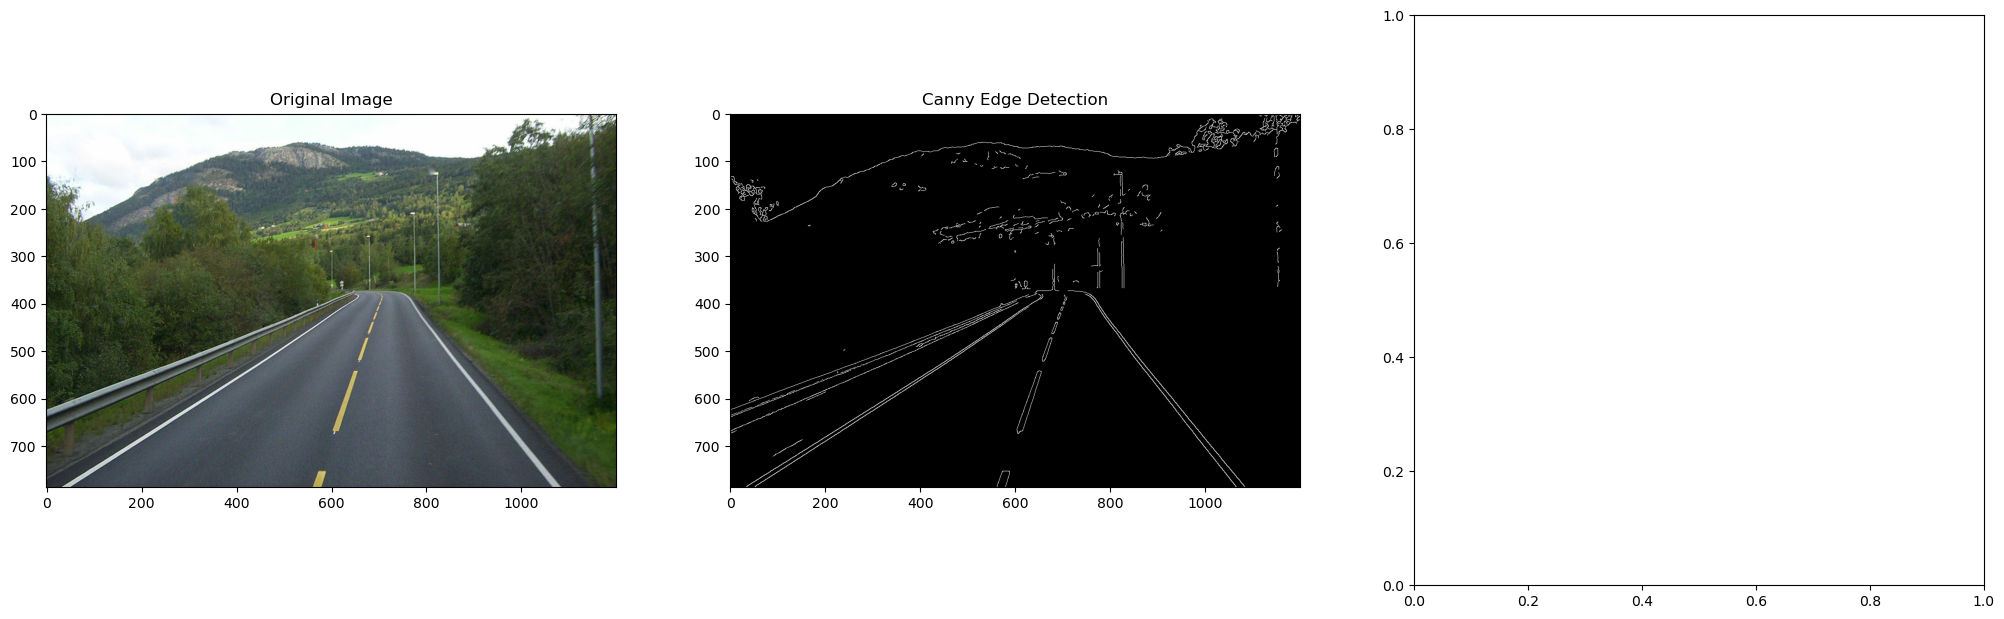

In [259]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_3.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img = roi(canny,tl=0.6)
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()


line_coords, polar_params = hough_transform(roi_img)
filtered_lines = non_max_suppression(polar_params,30, 5,3)
ht_mask = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
mask_lines = np.zeros(img.shape, dtype="uint8")
for line in filtered_lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 2000 * (-b))  
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    
    cv2.line(mask_lines, (x1,y1), (x2,y2), [0,255,0], 5)

mask_output = cv2.bitwise_and(mask_lines, mask_lines, mask=ht_mask[:,:,-1])
dilated_mask = cv2.dilate(mask_output, (5,5), iterations=5)
overlay = cv2.addWeighted(img2, 1, dilated_mask, 1, 0)

for line in line_coords:
    x1, y1, x2, y2 = line[0]
    cv2.line(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Hough Lines with Non Max Suppression')


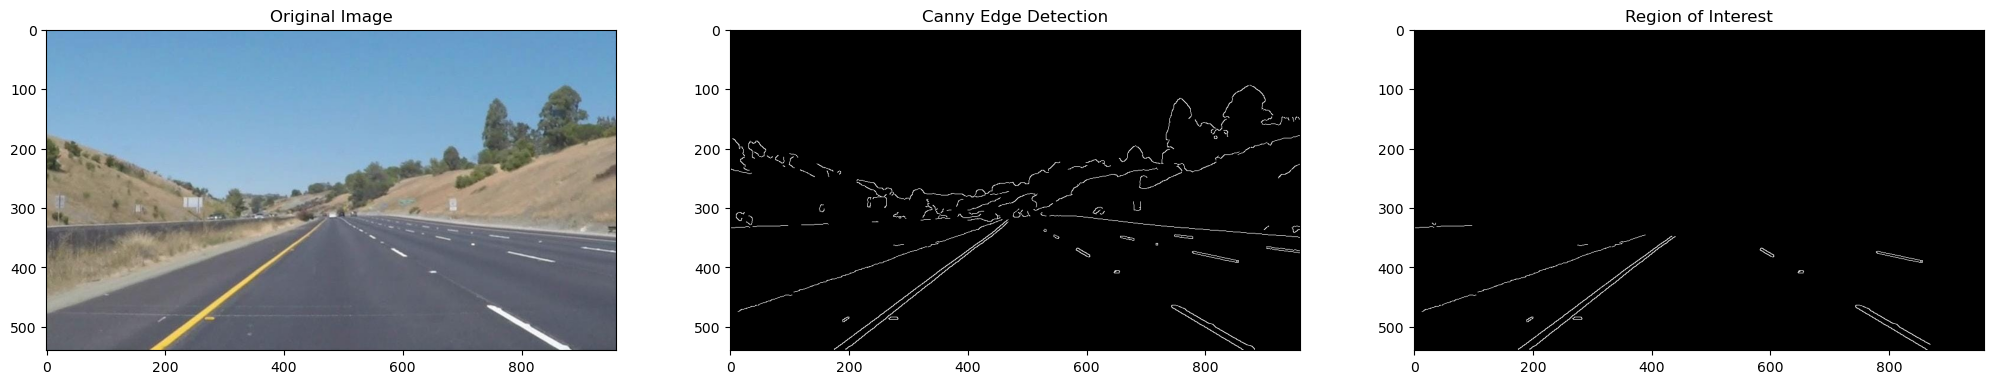

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

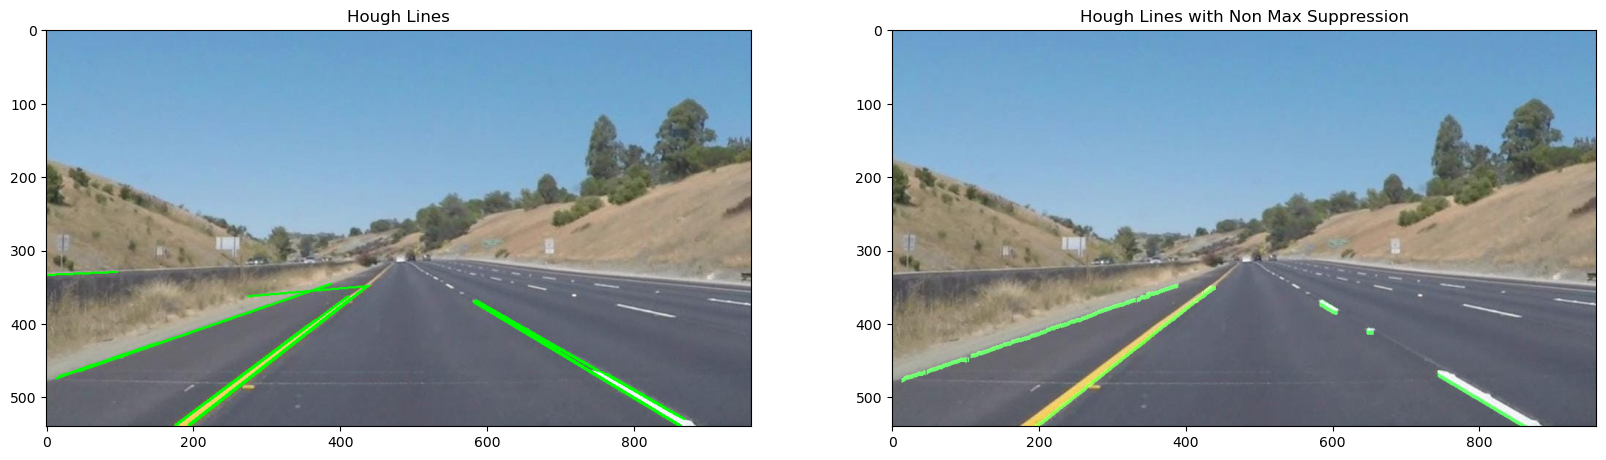

In [22]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_2.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img = roi(canny,tl=0.6,tr=(1,0.7))
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()


line_coords, polar_params = hough_transform(roi_img)
filtered_lines = non_max_suppression(polar_params,30, 5,3)
ht_mask = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
mask_lines = np.zeros(img.shape, dtype="uint8")
for line in filtered_lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 2000 * (-b))  
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    
    cv2.line(mask_lines, (x1,y1), (x2,y2), [0,255,0], 5)

mask_output = cv2.bitwise_and(mask_lines, mask_lines, mask=ht_mask[:,:,-1])
dilated_mask = cv2.dilate(mask_output, (5,5), iterations=5)
overlay = cv2.addWeighted(img2, 1, dilated_mask, 1, 0)

for line in line_coords:
    x1, y1, x2, y2 = line[0]
    cv2.line(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Hough Lines with Non Max Suppression')